In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as opt

from particle import literals as lp

from HNL_MC.hnl_tools import get_Rapp

In [2]:
def beta(gamma):
    return np.sqrt(1 - 1/gamma**2)

def p_to_gamma(p, parent):
    beta_gamma = p/parent.mass    
    return np.sqrt(beta_gamma**2 + 1)
    
def E_N_CM(m_N, m_parent=lp.K_plus.mass, m_other_daughter=lp.mu_plus.mass):
    return (m_parent**2 - m_other_daughter**2 + m_N**2)/(2*m_parent)

def E_N_lab(e_N_CM, m_N, gamma_parent, cos_theta_CM):
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    return e_N_CM*gamma_parent + beta(gamma_parent)*gamma_parent*p_N_CM*cos_theta_CM

def costheta_cm_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent=lp.K_plus.mass, m_other_daughter=lp.mu_plus.mass):
    e_N_CM = E_N_CM(m_N, m_parent, m_other_daughter)
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    out = (e_N_lab - e_N_CM*gamma_parent)/(beta(gamma_parent)*gamma_parent*p_N_CM)
    return np.where(np.abs(out)<1, out, np.nan)

def TanTheta_lab(e_N_CM, m_N, gamma_parent, cos_theta_CM):
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    return p_N_CM*np.sqrt(1-cos_theta_CM**2)/(gamma_parent*p_N_CM*cos_theta_CM + beta(gamma_parent)*gamma_parent*e_N_CM)

def Theta_lab(e_N_CM, m_N, gamma_parent, cos_theta_CM):
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    return np.arctan2(p_N_CM*np.sqrt(1-cos_theta_CM**2), (gamma_parent*p_N_CM*cos_theta_CM + beta(gamma_parent)*gamma_parent*e_N_CM))

def TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent=lp.K_plus.mass, m_other_daughter=lp.mu_plus.mass):
    e_N_CM = E_N_CM(m_N, m_parent, m_other_daughter)
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    return beta(gamma_parent)*gamma_parent*p_N_CM *\
           np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
           (gamma_parent*e_N_lab-e_N_CM)

def R_given_l(l, theta_0=2*np.pi/180, R0=280):
    return np.sqrt(R0**2 - 2*R0*l*np.cos(theta_0) + l**2)

def Theta_given_l(l, theta_0=2*np.pi/180, R0=280):
    return np.arcsin(R0*np.sin(theta_0)/R_given_l(l, theta_0, R0))

def TanTheta_given_l(l, theta_0=2*np.pi/180, R0=280):
    return R0*np.sin(theta_0)/(R0*np.cos(theta_0) - l)

def l_from_E_N_lab(e_N_lab, m_N, gamma_parent, theta_0=2*np.pi/180, R0=280, m_parent=lp.K_plus.mass, m_other_daughter=lp.mu_plus.mass):
    return R0*np.cos(theta_0)*(1-np.tan(theta_0)/TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent, m_other_daughter))

def dl_dsintheta_lab(l, theta_0=2*np.pi/180, R0=280):
    return (l**2+R0**2-2*l*R0*np.cos(theta_0))**(3/2)/(R0*np.sin(theta_0)*(R0*np.cos(theta_0)-l))

def dcostheta_cm_dE_lab(m_N, gamma_parent, m_parent=lp.K_plus.mass, m_other_daughter=lp.mu_plus.mass):
    e_N_CM = E_N_CM(m_N, m_parent, m_other_daughter)
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    return 1/(beta(gamma_parent)*gamma_parent*p_N_CM)

In [3]:
def pdf_E_lab(e_N_lab, m_N, gamma_parent, theta_0=2*np.pi/180, R0=280, l_max=118, parent=lp.K_plus, m_other_daughter=lp.mu_plus.mass):
    e_N_CM = E_N_CM(m_N, parent.mass, m_other_daughter)
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    l = l_from_E_N_lab(e_N_lab, m_N, gamma_parent, theta_0, R0, parent.mass, m_other_daughter)
    ctau = beta(gamma_parent)*gamma_parent*3*10**8*parent.lifetime
    return np.where(np.logical_and(l>0, l<l_max), 
                    np.exp(-l/ctau)/ctau *\
                    dcostheta_cm_dE_lab(m_N, gamma_parent, parent.mass, m_other_daughter) *\
                    dl_dsintheta_lab(l, theta_0, R0),
                    0)

In [28]:
theta_lab = 2
m_N = 150
e_N_CM = E_N_CM(m_N)
gamma_parent = 2
theta_0=2*np.pi/180
R0=280

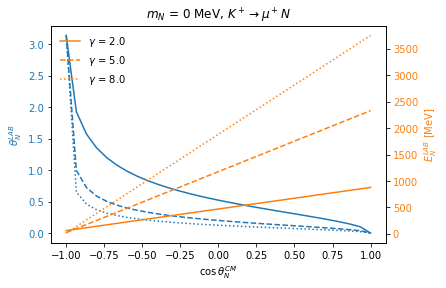

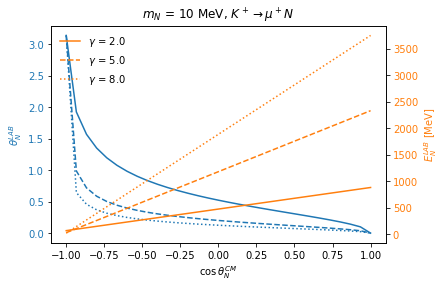

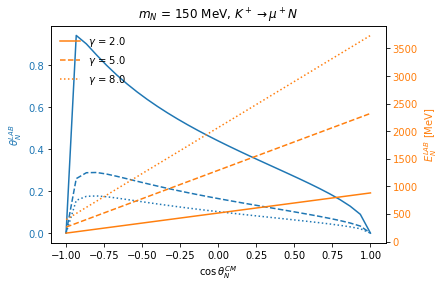

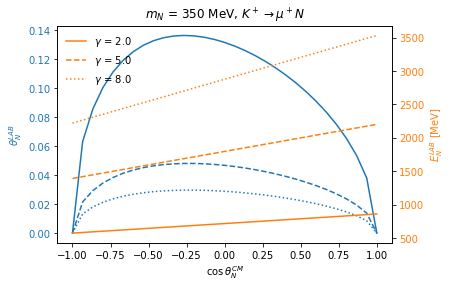

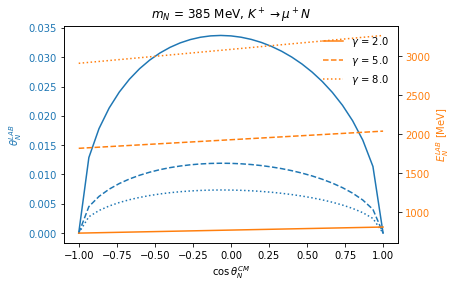

In [59]:
cos_theta_cm_test = np.linspace(-1, 1, 31)
gamma_test = np.linspace(2, 8, 3)
linestyles = ['solid', 'dashed', 'dotted']

for m_N in [0, 10, 150, 350, 385]:
    e_N_CM = E_N_CM(m_N)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for gamma, ls in zip(gamma_test, linestyles):
        this_theta_lab = Theta_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)
        this_E_N_lab = E_N_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)

        ax1.plot(cos_theta_cm_test, this_theta_lab, color='C0', label=f'$\gamma$ = {gamma}',
                 linestyle=ls)    
        ax2.plot(cos_theta_cm_test, this_E_N_lab, color='C1', label=f'$\gamma$ = {gamma}',
                 linestyle=ls)

    plt.legend(frameon=False)
    ax1.set_xlabel(r'$\cos\theta_N^{CM}$')
    plt.title(f'$m_N$ = {m_N} MeV,'+ r' $K^+ \rightarrow \mu^+ N$')
    ax1.set_ylabel(r'$\theta_N^{LAB}$', color='C0')
    ax1.tick_params(axis='y', labelcolor='C0')
    ax2.set_ylabel(r'$E_N^{LAB}$ [MeV]', color='C1')
    ax2.tick_params(axis='y', labelcolor='C1')
    plt.savefig(f'plots/AngularCorrelationFlux/m_N_{m_N}.png')

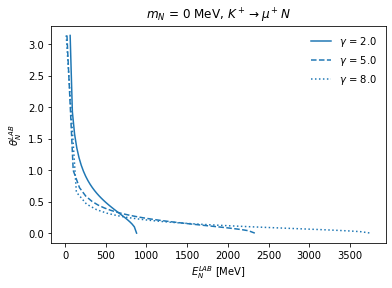

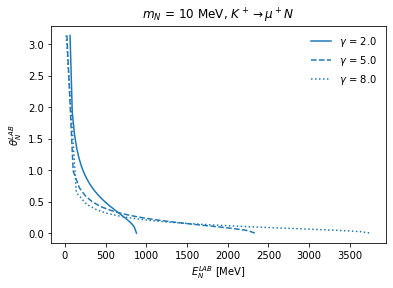

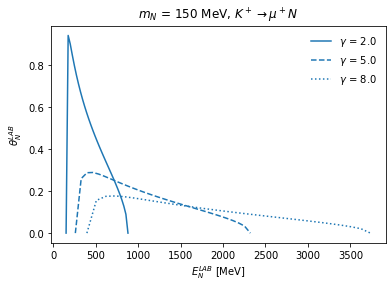

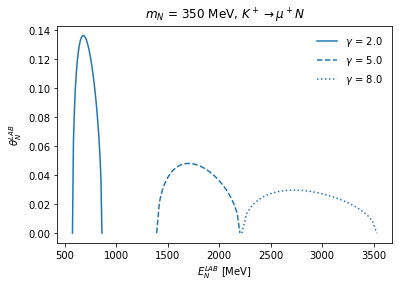

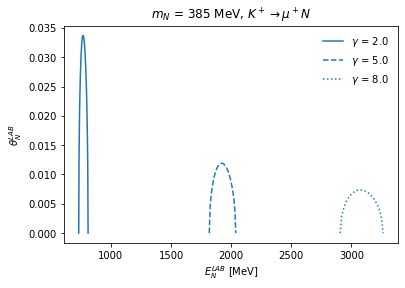

In [60]:
for m_N in [0, 10, 150, 350, 385]:
    e_N_CM = E_N_CM(m_N)
    plt.figure()
    for gamma, ls in zip(gamma_test, linestyles):
        this_theta_lab = Theta_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)
        this_E_N_lab = E_N_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)

        plt.plot(this_E_N_lab, this_theta_lab, color='C0', label=f'$\gamma$ = {gamma}',
                 linestyle=ls)    
    plt.legend(frameon=False)
    plt.xlabel(r'$E_N^{LAB}$ [MeV]')
    plt.ylabel(r'$\theta_N^{LAB}$')
    plt.title(f'$m_N$ = {m_N} MeV,'+ r' $K^+ \rightarrow \mu^+ N$')
    plt.savefig(f'plots/AngularCorrelationFlux/e_theta_lab_m_N_{m_N}.png')

<ipython-input-69-834934457498>:42: RuntimeWarning: divide by zero encountered in true_divide
  return R0*np.cos(theta_0)*(1-np.tan(theta_0)/TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent, m_other_daughter))
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:42: RuntimeWarning: divide by zero encountered in true_divide
  return R0*np.cos(theta_0)*(1-np.tan(theta_0)/TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent, m_other_daughter))
<ipython-input-69-834934457498>:42: RuntimeWarning: divide by zero encountered in true_divide
  return R0*np.cos(theta_0)*(1-np.tan(theta_0)/TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma_parent, m_parent, m_other_daughter))
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*ga

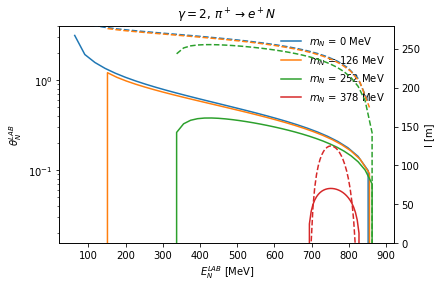

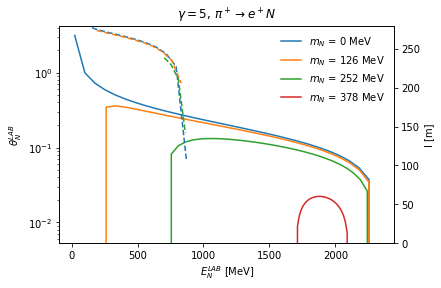

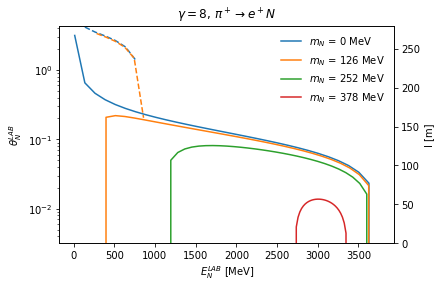

In [99]:
parent = lp.K_plus
other_daughter = lp.mu_plus
cos_theta_cm_test = np.linspace(-1, 1, 31)
gamma_test = [2, 5, 8]
linestyles = ['solid', 'dashed', 'dotted']


for gamma in gamma_test:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i, m_N in enumerate(np.linspace(0, parent.mass-other_daughter.mass-10, 4)):
        e_N_CM = E_N_CM(m_N, m_parent=parent.mass, m_other_daughter=other_daughter.mass)
        this_theta_lab = Theta_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)
        this_E_N_lab = E_N_lab(e_N_CM, m_N, gamma, cos_theta_cm_test)
#         this_E_N_lab = this_E_N_lab[this_theta_lab!=0]
#         this_theta_lab = this_theta_lab[this_theta_lab!=0]
        ax1.plot(this_E_N_lab, this_theta_lab, f'C{i}-', label=f'$m_N$ = {m_N:.3g} MeV')
        l = l_from_E_N_lab(this_E_N_lab, m_N, gamma_parent, 
                           theta_0, R0, m_parent=parent.mass, m_other_daughter=other_daughter.mass)
        ax2.plot(this_E_N_lab, l, f'C{i}--', label=f'$m_N$ = {m_N:.3g} MeV')
    ax1.legend(frameon=False)
    ax1.set_xlabel(r'$E_N^{LAB}$ [MeV]')
    ax1.set_ylabel(r'$\theta_N^{LAB}$')
    ax2.set_ylabel(r'l [m]')
    ax2.set_ylim(0, 280)
    ax1.set_title(f'$\gamma = {gamma}$,'+ r' $\pi^+ \rightarrow e^+ N$')
    ax1.set_yscale('log')
    plt.savefig(f'plots/AngularCorrelationFlux/pion_e_e_theta_lab_gamma_{gamma}.png')

<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_p

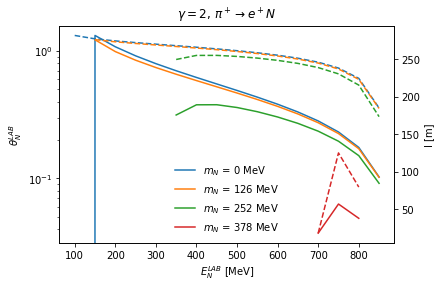

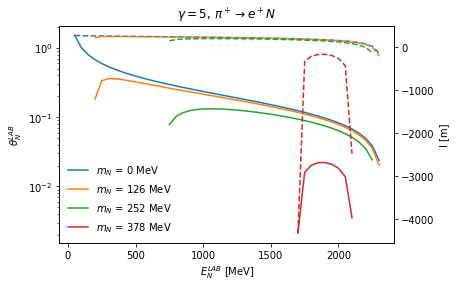

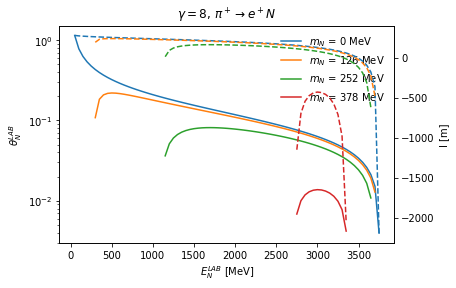

In [97]:
parent = lp.K_plus
other_daughter = lp.mu_plus
e_N_lab = np.linspace(0.1, 5000, 101)
gamma_test = [2, 5, 8]
linestyles = ['solid', 'dashed', 'dotted']


for gamma in gamma_test:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i, m_N in enumerate(np.linspace(0, parent.mass-other_daughter.mass-10, 4)):
        this_theta_lab = np.arctan(TanTheta_lab_from_E_N_lab(e_N_lab, m_N, gamma, 
                                                             m_parent=parent.mass, 
                                                             m_other_daughter=other_daughter.mass))
        ax1.plot(e_N_lab, this_theta_lab, f'C{i}-', label=f'$m_N$ = {m_N:.3g} MeV')
        l = l_from_E_N_lab(e_N_lab, m_N, gamma, 
                           theta_0, R0, m_parent=parent.mass, m_other_daughter=other_daughter.mass)
        ax2.plot(e_N_lab, l, f'C{i}--', label=f'$m_N$ = {m_N:.3g} MeV')
    ax1.legend(frameon=False)
    ax1.set_xlabel(r'$E_N^{LAB}$ [MeV]')
    ax1.set_ylabel(r'$\theta_N^{LAB}$')
    ax2.set_ylabel(r'l [m]')
    ax1.set_title(f'$\gamma = {gamma}$,'+ r' $\pi^+ \rightarrow e^+ N$')
    ax1.set_yscale('log')
    plt.savefig(f'plots/AngularCorrelationFlux/pion_e_e_theta_lab_gamma_{gamma}.png')

## Comparing two formulas for $\tan \theta^{LAB}$

In [71]:
parent = lp.K_plus
other_daughter = lp.mu_plus
cos_theta_cm_test = np.linspace(-1, 1, 31)
gamma_parent = 2
m_N = 10
e_N_CM = E_N_CM(m_N, m_parent=parent.mass, m_other_daughter=other_daughter.mass)

elab = np.linspace(0, 1000, 20)
tantheta_simple = TanTheta_lab_from_E_N_lab(elab, m_N, gamma_parent, m_parent=parent.mass, m_other_daughter=other_daughter.mass)
costheta_cm_complex = costheta_cm_from_E_N_lab(elab,  m_N, gamma_parent, m_parent=parent.mass, m_other_daughter=other_daughter.mass)
tantheta_complex = TanTheta_lab(e_N_CM, m_N, gamma_parent, costheta_cm_complex)

<ipython-input-69-834934457498>:29: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\


# PDF studies

In [4]:
pdf_E_lab_v = np.vectorize(pdf_E_lab, excluded=['R0', 'parent', 'm_other_daughter'])

<ipython-input-5-1886d16d37b6>:3: RuntimeWarning: divide by zero encountered in power
  phi_h = a_h*(pk + p_0)**(-b_h)
<ipython-input-5-1886d16d37b6>:5: RuntimeWarning: invalid value encountered in multiply
  phi_l * phi_h /(phi_l + phi_h))


Text(0.5, 1.0, '$20 \\leq \\theta \\leq 140$ mrad')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: computer modern roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: computer modern roman


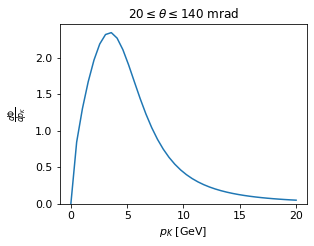

In [5]:
def pk_pdf(pk, a_l=1.285, b_l=0.6289, a_h=793.5, b_h=3.230, p_0=0):
    phi_l = a_l * pk**b_l
    phi_h = a_h*(pk + p_0)**(-b_h)
    return np.where(pk==0, 0,
                    phi_l * phi_h /(phi_l + phi_h))

pk = np.linspace(0, 20, 40)
plt.plot(pk, pk_pdf(pk))
plt.ylim(bottom=0)
plt.xlabel(r'$p_K$ [GeV]')
plt.ylabel(r'$\frac{d\Phi}{dp_K}$')
plt.title(r'$20 \leq \theta \leq 140$ mrad')

In [232]:
energies = np.linspace(0, 10000, 50)
gam = np.linspace(1, 30, 2000)
pk_s = gam * beta(gam) * lp.K_plus.mass/1000
pdf_values = pk_pdf(pk_s)
out = pdf_E_lab_v(energies.reshape(len(energies), 1, 1),
            np.asarray([150, 250]).reshape(1, 2, 1),
            gam.reshape(1, 1, 2000),)
#                  theta_0=1.48*np.pi/180)
out2 = (out * pdf_values).sum(axis=2)

<ipython-input-210-1886d16d37b6>:3: RuntimeWarning: divide by zero encountered in power
  phi_h = a_h*(pk + p_0)**(-b_h)
<ipython-input-210-1886d16d37b6>:5: RuntimeWarning: invalid value encountered in multiply
  phi_l * phi_h /(phi_l + phi_h))
<ipython-input-136-a7c15ebe5a83>:33: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-136-a7c15ebe5a83>:33: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-136-a7c15ebe5a83>:54: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(beta(gamma_parent)*gamma_parent*p_N_CM)


In [235]:
flux.max()/1e21/(out2[:, i].max()*get_Rapp(mass/1000))

0.007297035101896514

Text(0.5, 1.0, ' $K^+ \\rightarrow \\mu^+ N$')

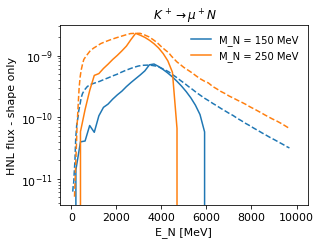

In [236]:
for i, mass in enumerate([150, 250]):
    plt.plot(energies, 0.00729*out2[:, i]*get_Rapp(mass/1000), f'C{i}-', label=f'M_N = {mass} MeV')
    EN, flux = np.genfromtxt(f"digitized/T2K_HNL_fluxes/m4_{mass}_MeV_KmuN.dat", unpack = True)
    plt.plot(1000*EN, flux/1e21, f'C{i}--')
    
plt.legend(frameon=False)
plt.yscale('log')
plt.xlabel('E_N [MeV]')
plt.ylabel('HNL flux - shape only')
plt.title(r' $K^+ \rightarrow \mu^+ N$')

In [72]:
energies = np.linspace(0, 10000, 100)
gam = np.linspace(1, 30, 200)
theta_0_s = np.linspace(0.5, 3.5, 21)*np.pi/180
pk_s = gam * beta(gam) * lp.K_plus.mass/1000
pdf_values = pk_pdf(pk_s)
out = pdf_E_lab_v(energies.reshape(len(energies), 1, 1, 1),
            np.asarray([150, 250]).reshape(1, 2, 1, 1),
            gam.reshape(1, 1, len(gam), 1),
                 theta_0_s.reshape(1, 1, 1, len(theta_0_s)))
out2 = (out * pdf_values.reshape(1, 1, len(gam), 1)).sum(axis=2)

<ipython-input-5-1886d16d37b6>:3: RuntimeWarning: divide by zero encountered in power
  phi_h = a_h*(pk + p_0)**(-b_h)
<ipython-input-5-1886d16d37b6>:5: RuntimeWarning: invalid value encountered in multiply
  phi_l * phi_h /(phi_l + phi_h))
<ipython-input-2-a7c15ebe5a83>:33: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-2-a7c15ebe5a83>:33: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\
<ipython-input-2-a7c15ebe5a83>:54: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(beta(gamma_parent)*gamma_parent*p_N_CM)


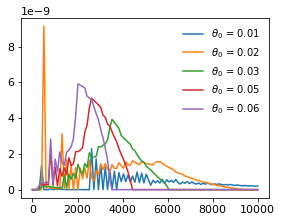

In [73]:
for i, theta in enumerate(theta_0_s):
    if i%5 == 0:
        plt.plot(energies, out2[:, 0, i], label=f'$\\theta_0$ = {theta:.2f}')
    
plt.legend(frameon=False)

In [74]:
out3 = (out2*np.exp(-(theta_0_s-theta_0)**2/(2*1**2))).sum(axis=2)

In [80]:
flux.max()/1e21/(out3[:, 1].max()*get_Rapp(250/1000))

0.0055971522826472045

Text(0.5, 1.0, ' $K^+ \\rightarrow \\mu^+ N$')

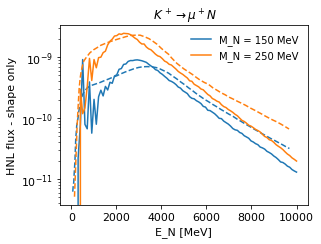

In [81]:
for i, mass in enumerate([150, 250]):
    plt.plot(energies, 0.006*out3[:, i]*get_Rapp(mass/1000), f'C{i}-', label=f'M_N = {mass} MeV')
    EN, flux = np.genfromtxt(f"digitized/T2K_HNL_fluxes/m4_{mass}_MeV_KmuN.dat", unpack = True)
    plt.plot(1000*EN, flux/1e21, f'C{i}--')
    
plt.legend(frameon=False)
plt.yscale('log')
plt.xlabel('E_N [MeV]')
plt.ylabel('HNL flux - shape only')
plt.title(r' $K^+ \rightarrow \mu^+ N$')

In [206]:
def full_pdf_E_lab(pk, e_N_lab, m_N, theta_0=2*np.pi/180, R0=280, l_max=118, parent=lp.K_plus, m_other_daughter=lp.mu_plus.mass, a_l=1.285, b_l=0.6289, a_h=793.5, b_h=3.230, p_0=0):
    phi_l = a_l * pk**b_l
    phi_h = a_h*(pk + p_0)**(-b_h)
    dphi_dpk = phi_l * phi_h /(phi_l + phi_h)
    gamma_parent = p_to_gamma(pk*1000, parent)
    e_N_CM = E_N_CM(m_N, parent.mass, m_other_daughter)
    p_N_CM = np.sqrt(e_N_CM**2 - m_N**2)
    l = l_from_E_N_lab(e_N_lab, m_N, gamma_parent, theta_0, R0, parent.mass, m_other_daughter)
    ctau = beta(gamma_parent)*gamma_parent*3*10**8*parent.lifetime
    return np.where(np.logical_and(pk!=0, np.logical_and(l>0, l<l_max)), 
                    dphi_dpk *\
                    np.exp(-l/ctau)/ctau *\
                    dcostheta_cm_dE_lab(m_N, gamma_parent, parent.mass, m_other_daughter) *\
                    dl_dsintheta_lab(l, theta_0, R0),
                    0)

In [194]:
import vegas 
import gvar

m_N = 150
def integral_function(x):
    return full_pdf_E_lab(x[0], x[1], m_N)

def integral_function_batch(x):
    return full_pdf_E_lab(x[:,0], x[:,1], m_N)

integ = vegas.Integrator([[0, 40], [0, 15000]])

integ(integral_function, nitn=100, neval=10000)

result = integ(integral_function, nitn=100, neval=10000)

print(result.summary())

<ipython-input-136-a7c15ebe5a83>:33: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   6.226(81)e-07   6.226(81)e-07       0.00     1.00
  2   6.25(13)e-07    6.232(69)e-07       0.02     0.88
  3   6.058(40)e-07   6.102(35)e-07       2.35     0.10
  4   6.094(62)e-07   6.100(30)e-07       1.57     0.19
  5   6.033(39)e-07   6.075(24)e-07       1.65     0.16
  6   6.34(26)e-07    6.077(24)e-07       1.52     0.18
  7   6.021(41)e-07   6.063(21)e-07       1.50     0.17
  8   6.230(95)e-07   6.070(20)e-07       1.71     0.10
  9   6.100(43)e-07   6.076(18)e-07       1.54     0.14
 10   6.300(67)e-07   6.091(18)e-07       2.52     0.01
 11   6.161(38)e-07   6.103(16)e-07       2.55     0.00
 12   6.103(37)e-07   6.103(15)e-07       2.32     0.01
 13   6.139(37)e-07   6.108(14)e-07       2.19     0.01
 14   6.139(36)e-07   6.112(13)e-07       2.07     0.01
 15   6.183(37)e-07   6.120(12)e-07       2.16     0.01
 16   6.187(53)e-07   6.123(12)e-07       2.12  

In [195]:
integral = 0.0
variance = 0.0
x_s = []
wgt_s = []
for i in range(1):
    for x, wgt, hcube in integ.random_batch(yield_hcube=True):
        wgt_fx = wgt * integral_function_batch(x)
        x_s.append(x)
        wgt_s.append(wgt_fx)
        # iterate over hypercubes: compute variance for each,
        #                          and accumulate for final result
        for i in range(hcube[0], hcube[-1] + 1):
            idx = (hcube == i)          # select array items for h-cube i
            nwf = np.sum(idx)           # number of points in h-cube i
            wf = wgt_fx[idx]
            sum_wf = np.sum(wf)         # sum of wgt * f(x) for h-cube i
            sum_wf2 = np.sum(wf ** 2)   # sum of (wgt * f(x)) ** 2
            integral += sum_wf
            variance += (sum_wf2 * nwf - sum_wf ** 2) / (nwf - 1.)
    # answer = integral;   standard deviation = variance ** 0.5
    result = gvar.gvar(integral, variance ** 0.5)

<ipython-input-136-a7c15ebe5a83>:33: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1-((e_N_lab-gamma_parent*e_N_CM)/(beta(gamma_parent)*gamma_parent*p_N_CM))**2)/\


In [196]:
x_s = np.concatenate(x_s)

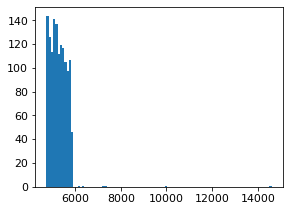

In [197]:
plt.hist(x[:, 1], bins=101);

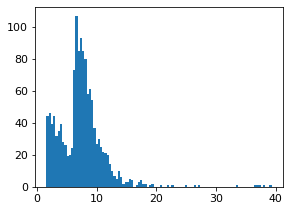

In [198]:
plt.hist(x[:, 0], bins=101);